<h1 style="display: inline-block; margin-right: -30px;">強化学習AIを作ろう</h1>
<img src="img/magician.png" style="display: inline-block; vertical-align: middle; width: 80px; height: auto;" />

このワークでは、オリジナルの学習環境と、その環境内で、試行錯誤してゲームをクリアするAIを構築します。  
環境の確認から始め、Q-tableの表示、AIの学習、そしてGradioを用いたゲームの作成までを行います。

## 目次
- 必要なライブラリのインポート
- 学習環境(Environment)の確認
- Q-Tableの確認
- ランダムAIの作成
- 強化学習AIの学習と作成
- 【応用】強化学習ゲームを作成

# 必要なライブラリをインストールします
! pip install onnxruntime
! pip install torch
! pip install japanize_matplotlib
! pip install gradio==3.50.0
! pip install pydot
! pip install typing_extensions
! pip install sqlalchemy
! pip install pymysql
! pip install google-cloud-storage## 必要なライブラリのインポートや準備
まず、今回の学習モデルに必要なライブラリのインポートをしていきましょう

In [1]:
# 必要なライブラリをインストールします
! pip install onnxruntime
! pip install torch
! pip install packaging==22
! pip install japanize_matplotlib
! pip install gradio==3.50.0
! pip install pydot
! pip install typing_extensions
! pip install sqlalchemy
! pip install pymysql
! pip install google-cloud-storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 32.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from utils import cloud_glider as cg  # ユーティリティライブラリから強化学習をするのに必要なものをインポート
from IPython.display import HTML #　環境のアニメーションを表示するために必要なモジュールをインポート

インポートができたら、強化学習を行うのに必要なクラスを定義していきます。  
今回必要なのは、エージェント(AI)の意思決定を行う`Brain`クラスと、動かすAIとなる`Agent`クラス、  
そして今回学習する環境となる`Environment`クラスなので、この3つを用意していきましょう。

In [3]:
# エージェント(AI)をコントロールするBrainクラスを定義
brain = cg.Brain()

In [4]:
# エージェントを定義
agent = cg.Agent(brain) # 引数に、ひとつ前で定義したbrainを渡します

In [5]:
# 環境を定義
# 引数に、ひとつ前で定義したagentを定義し、num_obstraclesに環境に存在する障害物の数を定義します。
env = cg.Environment(agent=agent, num_obstacles=1) 

これで準備は完了です。

<hr style="border-top: 2px solid #71EB8B;">

## 学習環境(Environment)の確認

では、まず今回強化学習AIに学習してもらう環境を確認してみましょう。  
環境を確認するには、先ほどインポートしたcloud_gliderモジュールの省略、`cg`から`show_env_animation`を呼び出し、  
引数に先ほど定義したenvクラスと、今回は環境を確認したいだけなので、framesに0を指定します。  
こうすることによって、学習する環境の初期状態の画像を取得することができます。

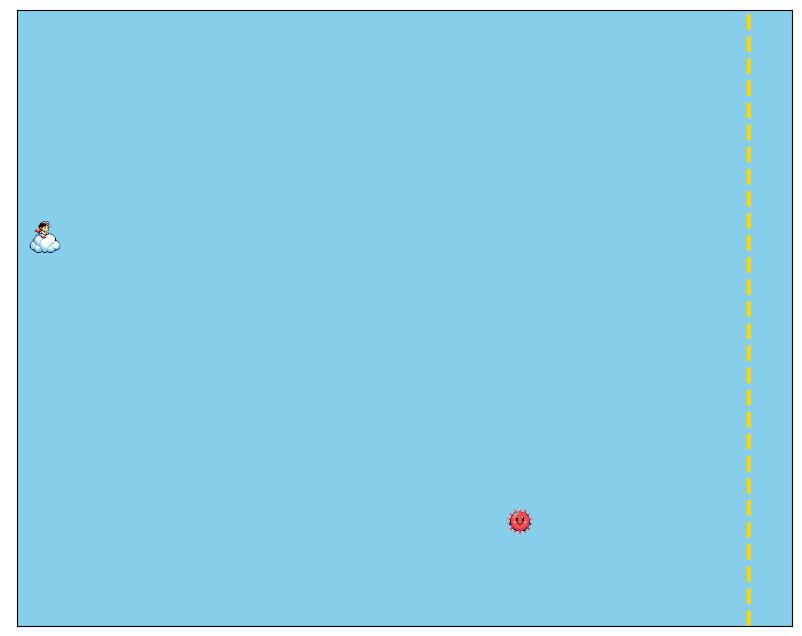

In [6]:
# 環境の初期状態を表示
cg.show_env_animation(env, frames=0)

<hr style="border-top: 2px solid #71EB8B;">

## Q-Tableの確認
次に、今回の環境を表している`Q-Table`の確認を行いましょう。  
講義パートで説明したように、`Q-Learning`という手法で強化学習AIを作成する場合、`Q-Table`を作る必要があります。  
エージェント(AI)は学習して報酬を得ていくことによって、この`Q-Table`の値、つまり`Q値`を更新していきます。  
では`Q-Table`を確認するために、先ほど用意した変数`brain`の`show_q_table`メソッドを呼び出してみましょう。

In [7]:
# Q-Tableを確認
brain.show_q_table()

,行動: a1,行動: a2
状態,,
s1,0.0,0.0
s2,0.0,0.0
s3,0.0,0.0
s4,0.0,0.0
s5,0.0,0.0
...,...,...
s396,0.0,0.0
s397,0.0,0.0
s398,0.0,0.0


`Q-Table`の状態が`s1~s400`の`400個`あり、行動が`a1`と`a2`の`２つ`あるのが確認できるでしょうか？  
行動が2つあるのは、講義の時のゲーム環境の説明であったように、このAIは`何もしない`という行動と、`ジャンプする`の二つの行動ができるためです。  
状態が400個あるのは、AIの垂直方向の位置と現在持っている速度を、値からそれぞれ`1~20`の値のグループに分割しているからです。  
垂直方向の位置のグループ20個と速度のグループ20個の組み合わせで、`20 × 20 = 400` の状態を作っています。  
<span style="color:#E5004C"> **ここで大事なのは、`Q-Learning`をするためには、このように環境の全ての状態と行動を表した`Q-Table`を作る必要があるということです。** </span>  
また、`Q-Table`に入っているそれぞれの値は、0で初期化されています。  
この値を、学習して報酬を得ることによって、調整していきます。  
では、いよいよAIにこの環境をプレイさせてみましょう。

<hr style="border-top: 2px solid #71EB8B;">

## ランダムAIの作成
`Q-Table`の確認が終わったので、用意した環境にAIをプレイさせてみましょう。  
まずは、学習しないで、ランダムで、`何もしない`行動か`ジャンプする`行動かのどれかをとり続けるAIを作成して遊ばせてみます。  
定義したライブラリの`cg`にある`create_animation`を呼び出し、引数に、学習する環境の動画の時間である90秒と、作った環境の`env`、  
そして、今回はランダムで行動するため、`random=True`を定義して実行してみます。

In [8]:
#　ランダムAIでゲームをプレイ
anim = cg.create_animation(max_time_input=90, env=env, random=True)
HTML(anim.to_html5_video())

どうでしょうか？  AIは一度でもゴールに辿り着くことができたでしょうか？  
完全ランダムなので、運が良ければ辿り着くかもしれませんが、行動に一貫性がなく、ほとんどのパターンでうまくいかないと思います。

<hr style="border-top: 2px solid #71EB8B;">

## 強化学習AIの学習と作成
ランダムAIの動作が確認できたので、最後に強化学習AIを作成して、動作を比較してみましょう。  
先ほどと同じように`create_animation`を呼び出し、引数の`random`のところを`random=False`に修正すれば、  
強化学習AIが学習しながら環境をプレイしてくれます。

In [9]:
#　強化学習AIでゲームをプレイ
anim = cg.create_animation(max_time_input=90, env=env)
HTML(anim.to_html5_video())

ランダムAIと比較してどうでしょうか？  
後半になっていくほど、AIがゴールに近づいて、後半にはゴールできるようになっているでしょうか？  
また、中盤くらいで一度ゴールできると、ゴールの報酬がもらえるので、それ以降はゴールしやすくなります。  
また、今回は1分30秒くらいの動画なのでそこまでうまくはいかないことが多いですが、ゲームの攻略法を理解すると、  
その通りに強化学習AIがプレイしてくれるようになったりします。  

<hr style="border-top: 2px solid #71EB8B;">

## 【応用】強化学習ゲームの作成

最後に、Gradioを使用して、先ほどの環境の状態を色々試してプレイできるゲームを作成します。  
下記のコードを実行したら、`Running on public URL`の右側にあるリンクをクリックしてみてください。   
障害物と学習する時間を増やすことができ、それによってスコアがもらえるので、より難しい環境をクリアするAIを作って、  
高スコアを狙ってみましょう！

In [10]:
import gradio as gr

with gr.Blocks(theme=gr.themes.Soft()) as app:
    state = gr.State({
        "env": None
    })
    
    # ゲームのタイトルと説明
    gr.Markdown("<div style='text-align: center;'><h1>クラウドグライダー</h1><h3>障害物を避けながらゴールを目指そう</h3></div>")
    
    with gr.Row():
        with gr.Column(scale=5):
            user_name = gr.Textbox(label="ユーザー名", placeholder="ユーザー名を入力")
            max_time_input = gr.Number(label="学習時間(秒)", value=90)
            num_obstacles_input = gr.Number(label="障害物の数", value=0)
            desc_output = gr.Textbox(label="説明", value="「ユーザー名」に名前を入力して「開始」ボタンを押してください。", interactive=False)
            with gr.Row():
                start_button = gr.Button("開始", variant="primary")
                clear_button = gr.Button("クリア")
            progress_textbox = gr.Textbox(label="進行状況", lines=13, max_lines=13, interactive=False)
        with gr.Column(scale=5):
            animation_output = gr.Video(label="ビデオ", height=540)
            score_board = gr.Textbox(label="スコアボード", lines=8, max_lines=8, interactive=False)
            
    start_button.click(fn=cg.create_animation_in_gr, inputs=[max_time_input, state, num_obstacles_input, user_name, animation_output], outputs=[animation_output, desc_output])
    clear_button.click(fn=cg.clear_user_name, outputs=[user_name, desc_output])
    animation_output.change(fn=cg.update_result, inputs=[state, user_name, score_board], outputs=[desc_output, score_board, progress_textbox])

app.queue().launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://df563386625c7a8408.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
